<a href="https://colab.research.google.com/github/galib96/lung-nodule-malignancy/blob/main/Lung_nodule_malignancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, ZeroPadding2D, Add
from keras.layers import BatchNormalization, AveragePooling2D, Conv2D, MaxPooling2D, Input, ReLU
from keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.optimizers import Adam

In [3]:
# importing dataset
img_data = h5py.File("/content/drive/MyDrive/Colab Notebooks/Lung Nodule Maliganancy/all_patches.hdf5",'r')
print(list(img_data.keys()))

['ct_slices', 'slice_class']


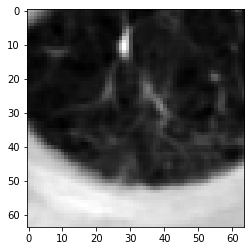

In [4]:
# visualizing image
ct_slices = img_data['ct_slices']
slice_class = img_data['slice_class']

plt.imshow(ct_slices[0], interpolation='nearest',cmap='gray')
plt.show()

In [5]:
print(ct_slices.shape)
print(slice_class.shape)
print(ct_slices[0].min())

(6691, 64, 64)
(6691, 1)
-1017.0


In [20]:
ct_slices = np.array(ct_slices)
slice_class = np.array(slice_class)
ct_slices = ct_slices.reshape(6691, 64, 64, 1)

# splitting data into train, validation and test set
x_train, x_t, y_train, y_t = train_test_split(ct_slices, slice_class, test_size = 0.3, random_state=11)
x_val, x_test, y_val, y_test = train_test_split(x_t, y_t, test_size = 0.5, random_state=11)

y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_val = keras.utils.to_categorical(y_val, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(4683, 64, 64, 1)
(1004, 64, 64, 1)
(1004, 64, 64, 1)
(4683, 2)
(1004, 2)
(1004, 2)


In [7]:
def identity_block(X, f, filters, stage, block):
    # defining names
    conv_name = 'res'+str(stage)+block+'_branch'
    bn_name = 'bn'+str(stage)+block+'_branch'

    # retrieve filters
    f1, f2, f3 = filters

    # save the input values
    X_skip = X

    # 1st component of main path
    X = Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name+'2a')(X)
    X = BatchNormalization(name=bn_name+'2a')(X)
    X = Activation('relu')(X)

    # 2nd component of main path
    X = Conv2D(filters=f2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name+'2b')(X)
    X = BatchNormalization(name=bn_name+'2b')(X)
    X = Activation('relu')(X)

    # 3rd component of main path
    X = Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name+'2c')(X)
    X = BatchNormalization(name=bn_name+'2c')(X)
    
    # Final Step
    X = Add()([X, X_skip])
    X = Activation('relu')(X)

    return X

In [8]:
def conv_block(X, f, filters, stage, block, s=2):
    # defining names
    conv_name = 'res'+str(stage)+block+'_branch'
    bn_name = 'bn'+str(stage)+block+'_branch'

    # retrieve filters
    f1, f2, f3 = filters

    # save the input values
    X_skip = X

    # 1st component of main path
    X = Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid', name=conv_name+'2a')(X)
    X = BatchNormalization(name=bn_name+'2a')(X)
    X = Activation('relu')(X)

    # 2nd component of main path
    X = Conv2D(filters=f2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name+'2b')(X)
    X = BatchNormalization(name=bn_name+'2b')(X)
    X = Activation('relu')(X)

    # 3rd component of main path
    X = Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name+'2c')(X)
    X = BatchNormalization(name=bn_name+'2c')(X)

    # res skip connection path
    X_skip = Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid', name=conv_name+'1')(X_skip)
    X_skip = BatchNormalization(name=bn_name+'1')(X_skip)
    
    # Final Step
    X = Add()([X, X_skip])
    X = Activation('relu')(X)

    return X

In [19]:
def ResNet(input_shape = (64, 64, 1), classes = 2):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = conv_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='d')

    # Stage 3
    X = conv_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    

    # Stage 4
    X = conv_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

In [21]:
# Creating function to get a untrained model from tensorflow
tf.keras.backend.clear_session()
tf.random.set_seed(11)

def get_model():
  model = ResNet()
  
  model.compile(
        loss='categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy']
    )
  
  return model

summary = get_model().summary()
summary

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']                  
                                                                                             

In [22]:
model = get_model()

# early stopping callback function
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10, mode="min",
    restore_best_weights=True,
)

# learning rate reduction
lr_reduce = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, verbose=1, mode='min'
)

# training model
history = model.fit(
    x_train, y_train,
    batch_size = 128,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks = [early_stop, lr_reduce]
)

Epoch 1/100
37/37 [==============================] - 7s 108ms/step - loss: 1.1811 - accuracy: 0.6485 - val_loss: 20.7686 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 3s 91ms/step - loss: 0.4375 - accuracy: 0.8012 - val_loss: 2.4147 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 3s 92ms/step - loss: 0.2622 - accuracy: 0.9005 - val_loss: 1.5497 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 3s 92ms/step - loss: 0.1660 - accuracy: 0.9340 - val_loss: 1.3155 - val_accuracy: 0.6315 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 3s 93ms/step - loss: 0.1472 - accuracy: 0.9438 - val_loss: 0.5795 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 3s 92ms/step - loss: 0.0832 - accuracy: 0.9684 - val_loss: 0.6561 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/100
37/37 [==============================] - 3s 93ms/step - 

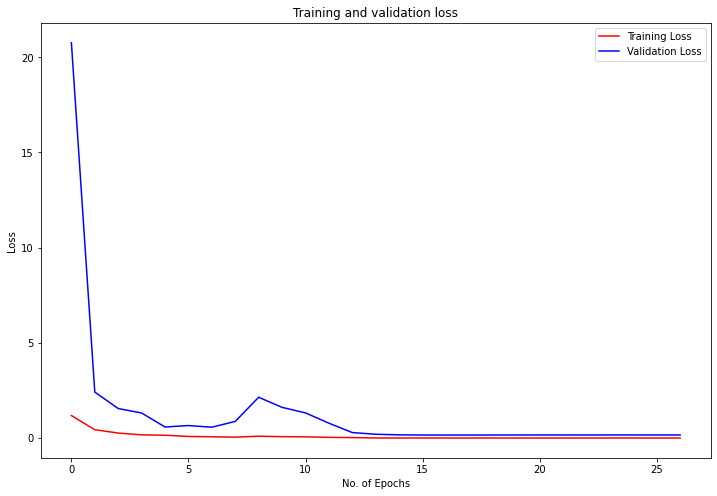

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()

#plt.savefig('/content'+'/Training and Validation Loss.png',dpi=300) ##########

plt.show()

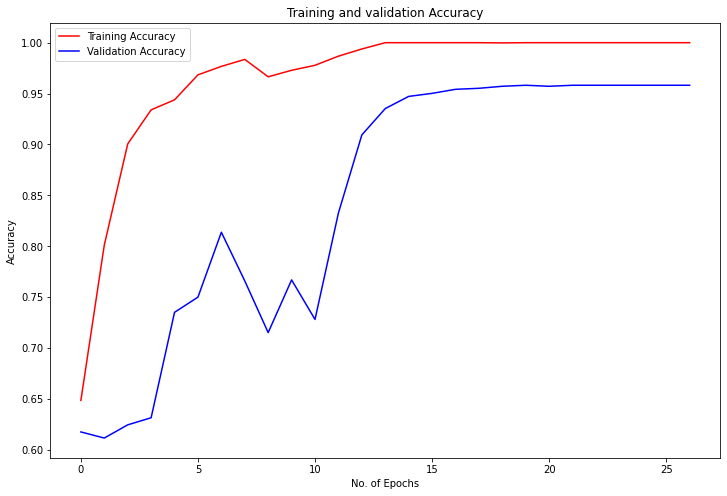

In [24]:
# result of the model training

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(loss))

plt.figure(figsize=(12,8))

plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('/content'+'/Training and Validation Accuracy.png',dpi=300) #########

plt.show()

In [29]:
# predicting classes for test set

yhat_probs = model.predict(x_test)
yhat_classes = np.argmax(yhat_probs,axis=1)
yhat_classes

array([0, 0, 0, ..., 0, 1, 0])

In [31]:
# converting test set to classes
y_test_class = np.argmax(y_test,axis=1)
y_test_class

array([0, 0, 0, ..., 0, 1, 0])

In [32]:
# model evaluation by f1 score

f1 = f1_score(y_test_class, yhat_classes)
print("F1 accuracy of the model for test set: ", f1)

F1 accuracy of the model for test set:  0.9341772151898735


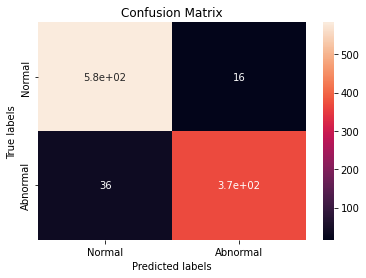

In [35]:
# plotting confusion matrix

cm = confusion_matrix(y_test_class, yhat_classes)

ax = plt.subplot(1,1,1)
sns.heatmap(cm, annot=True, ax = ax );

# labels and titles
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Normal', 'Abnormal']); 
ax.yaxis.set_ticklabels(['Normal', 'Abnormal']);

plt.show()

In [ ]:
!pip install -q pyyaml h5py

# saving model
model.save('model.h5')